In [ ]:
import tarfile
from collections import Counter
import os
import shutil
import glob
import re
import pandas as pd

In [ ]:

def extract_tar(file_path, extract_path='.'):
    """
    Extracts a .tar or .tar.gz file to the specified directory.

    Parameters:
        file_path (str): Path to the .tar file.
        extract_path (str): Directory where the files will be extracted.
    """
    with tarfile.open(file_path, 'r') as tar:
        tar.extractall(path=extract_path)
        print(f"Extracted '{file_path}' to '{extract_path}'")


In [ ]:
# Set this to the root folder that contains Session1, Session2, ...
root_dir = "IEMOCAP_data/IEMOCAP_full_release"

# Counter to accumulate all emotions
emotion_counts = Counter()

# Loop through all 5 sessions
for session_num in range(1, 6):
    session_path = os.path.join(root_dir, f"Session{session_num}", "dialog", "EmoEvaluation", "categorical")

    if not os.path.exists(session_path):
        continue

    for file in os.listdir(session_path):
        if file.endswith("_cat.txt"):
            file_path = os.path.join(session_path, file)
            with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
                for line in f:
                    parts = line.strip().split(":")
                    if len(parts) >= 2:
                        emotion = parts[1].split(";")[0].strip()
                        emotion_counts[emotion] += 1

# Print the final emotion distribution
print("Emotion Distribution:")
for emotion, count in emotion_counts.most_common():
    print(f"{emotion}: {count}")


Emotion Distribution:
Frustration: 7489
Neutral state: 6400
Excited: 4358
Anger: 3911
Sadness: 3521
Happiness: 2799
Other: 682
Surprise: 604
Fear: 260
Disgust: 93


In [ ]:
os.makedirs("data/IEMOCAP/audio", exist_ok=True)
os.makedirs("data/IEMOCAP/video", exist_ok=True)


# Move .wav files
wav_files = glob.glob("IEMOCAP_data/IEMOCAP_full_release/Session*/dialog/wav/*.wav", recursive=True)
for src in wav_files:
    dest = os.path.join("data/IEMOCAP/audio", os.path.basename(src))
    shutil.copy2(src, dest)

# Move .avi files
avi_files = glob.glob("IEMOCAP_data/IEMOCAP_full_release/Session*/dialog/avi/DivX/*.avi", recursive=True)
for src in avi_files:
    dest = os.path.join("data/IEMOCAP/video", os.path.basename(src))
    shutil.copy2(src, dest)

print(f"Copied {len(wav_files)} audio files and {len(avi_files)} video files.")


In [ ]:
import os
import re
import glob
import pandas as pd

# Map raw IEMOCAP emotions to your 7 emotion classes
label_map = {
    "angry": "Anger",
    "frustration": "Anger",
    "sad": "Sadness",
    "sadness": "Sadness",
    "happy": "Joy",
    "excited": "Joy",
    "neutral": "Neutral",
    "neutral_state": "Neutral",
    "disgusted": "Disgust",
    "disgust": "Disgust",
    "surprise": "Surprise",
    "fear": "Fear"
}

# Final allowed labels (standardized)
valid_labels = set(label_map.values())

# Store text and label entries
text_records = []
label_dict = {}

# Loop through all sessions
for i in range(1, 6):
    session = f"Session{i}"
    transcript_dir = f"IEMOCAP_data/IEMOCAP_full_release/{session}/dialog/transcriptions"
    label_dir = f"IEMOCAP_data/IEMOCAP_full_release/{session}/dialog/EmoEvaluation/categorical"

    # Parse utterance text
    for path in glob.glob(os.path.join(transcript_dir, "*.txt")):
        with open(path, encoding="utf-8", errors="ignore") as f:
            for line in f:
                line = line.strip()
                match = re.match(r"^(\S+)\s+\[\d+\.\d+-\d+\.\d+\]:\s*(.+)$", line)
                if match:
                    utt_id = match.group(1).strip()
                    text = match.group(2).strip()
                    text_records.append((utt_id, text))

    # Parse categorical labels, keep only first label per utt_id
    for path in glob.glob(os.path.join(label_dir, "*_cat.txt")):
        with open(path, encoding="utf-8", errors="ignore") as f:
            for line in f:
                if ":" in line and ";" in line:
                    parts = line.strip().split(":")
                    utt_id = parts[0].strip()
                    raw_label = parts[1].split(";")[0].strip().lower().replace(" ", "_")
                    mapped = label_map.get(raw_label)
                    if mapped in valid_labels and utt_id not in label_dict:
                        label_dict[utt_id] = mapped

# Convert to DataFrames
df_text = pd.DataFrame(text_records, columns=["utt_id", "text"])
df_labels = pd.DataFrame(list(label_dict.items()), columns=["utt_id", "label"])

# Merge & clean
df_text["utt_id"] = df_text["utt_id"].str.strip()
df_labels["utt_id"] = df_labels["utt_id"].str.strip()
df_merged = df_text.merge(df_labels, on="utt_id", how="inner").drop_duplicates()

# Save
os.makedirs("data/IEMOCAP", exist_ok=True)
df_merged.to_csv("data/IEMOCAP/iemocap_merged.csv", index=False)

# Summary
print(f"Saved {len(df_merged)} utterances with 7 emotion classes.")
print(df_merged["label"].value_counts())


✅ Saved 9549 utterances with 7 emotion classes.
label
Anger       4439
Joy         2617
Sadness     1263
Neutral      965
Fear         135
Surprise     109
Disgust       21
Name: count, dtype: int64


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Load merged CSV
import pandas as pd
df = pd.read_csv("data/IEMOCAP/iemocap_merged.csv")

# TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_text = tfidf.fit_transform(df["text"]).toarray()


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(df["label"])  # Now y is [0, 2, 1, ...]


In [ ]:
print(le.classes_)  # ['angry', 'excited', 'frustrated', 'happy', 'neutral', 'sad']


['Anger' 'Disgust' 'Fear' 'Joy' 'Neutral' 'Sadness' 'Surprise']


In [ ]:
import librosa
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import StandardScaler

# 1) Define MFCC extraction
def extract_mfcc_df(df, audio_dir="data/IEMOCAP/audio", sr=16000, n_mfcc=40):
    """
    For each utt_id in df, load {audio_dir}/{utt_id}.wav,
    compute mean MFCCs, and return a DataFrame indexed by utt_id.
    """
    mfcc_list = []
    utt_ids   = []

    for utt in tqdm(df["utt_id"], desc="Extracting MFCCs"):
        path = f"{audio_dir}/{utt}.wav"
        try:
            y, _   = librosa.load(path, sr=sr)
            mfcc   = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
            feats  = mfcc.mean(axis=1)
        except Exception:
            feats = np.zeros(n_mfcc)  # fallback for missing/bad files
        mfcc_list.append(feats)
        utt_ids.append(utt)

    mfcc_array = np.vstack(mfcc_list)
    cols       = [f"mfcc_{i}" for i in range(n_mfcc)]
    return pd.DataFrame(mfcc_array, index=utt_ids, columns=cols)

# 2) Extract and join
mfcc_df         = extract_mfcc_df(df)                                  # (n_samples × 40)
data_with_feats = df.set_index("utt_id").join(mfcc_df, how="inner")    # drop missing audio

# 3) Pull out features & labels
mfcc_cols = [f"mfcc_{i}" for i in range(mfcc_df.shape[1])]
X_mfcc    = data_with_feats[mfcc_cols].values                          # → (n_samples, 40)
y         = data_with_feats["label"].values                            # ← your target

# 4) Scale features
scaler    = StandardScaler()
X_scaled  = scaler.fit_transform(X_mfcc)

# 5) Train/test split (stratify on labels)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# 6) (Optional) Quick sanity check
print(f"→ X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"→ y_train: {y_train.shape}, y_test: {y_test.shape}")



Extracting MFCCs:   0%|          | 0/9549 [00:00<?, ?it/s]C:\Users\Hamza\AppData\Local\Temp\ipykernel_15408\1110463108.py:20: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _   = librosa.load(path, sr=sr)
c:\Users\Hamza\Desktop\IEMOCAP\.venv\lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Extracting MFCCs: 100%|██████████| 9549/9549 [00:04<00:00, 2316.40it/s]


→ X_train: (7639, 40), X_test: (1910, 40)
→ y_train: (7639,), y_test: (1910,)


In [ ]:
import cv2
import numpy as np
from tqdm import tqdm
import torch
from torchvision import models, transforms
from torch import nn

# 1) Load ResNet50 (minus the final FC), set to eval mode
resnet = models.resnet50(pretrained=True)
resnet = nn.Sequential(*list(resnet.children())[:-1])
resnet.eval()

# Optionally move to GPU if you have one:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = resnet.to(device)

# 2) Define your torchvision transform
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

def extract_video_features(df, video_dir="data/IEMOCAP/video"):
    feats = []
    for utt in tqdm(df["utt_id"], desc="Extracting video features"):
        path = f"{video_dir}/{utt}.avi"
        try:
            cap = cv2.VideoCapture(path)
            ret, frame = cap.read()
            cap.release()
            if not ret:
                raise RuntimeError(f"Couldn’t read frame from {path}")

            # OpenCV loads BGR; convert to RGB for PIL
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            img = transform(frame).unsqueeze(0).to(device)
            with torch.no_grad():
                feat = resnet(img)
                feat = feat.view(-1).cpu().numpy()
            feats.append(feat)
        except Exception as e:
            # on error, append a zero vector
            feats.append(np.zeros(2048))
    return np.vstack(feats)

# Usage:
X_video = extract_video_features(df)



c:\Users\Hamza\Desktop\IEMOCAP\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Hamza\Desktop\IEMOCAP\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Extracting video features: 100%|██████████| 9549/9549 [04:42<00:00, 33.85it/s]


In [ ]:
import os
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
import cv2
import librosa
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix


class MultimodalEmotionDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_text_length=128,
                 process_audio=True, process_video=True):
        self.df = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_text_length = max_text_length
        self.process_audio = process_audio
        self.process_video = process_video
        self.audio_dir = 'data/IEMOCAP/audio'
        self.video_dir = 'data/IEMOCAP/video'

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # Text
        text = row['clean_text']
        enc = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_text_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        text_features = {
            'input_ids': enc['input_ids'].squeeze(),
            'attention_mask': enc['attention_mask'].squeeze()
        }

        # Audio
        audio_feat = torch.zeros((128, 13), dtype=torch.float)
        if self.process_audio:
            ap = os.path.join(self.audio_dir, row['audio_file'])
            if os.path.exists(ap):
                y, _ = librosa.load(ap, sr=16000)
                mfcc = librosa.feature.mfcc(y=y, sr=16000, n_mfcc=13).T
                if mfcc.shape[0] < 128:
                    pad = np.zeros((128-mfcc.shape[0], 13))
                    mfcc = np.vstack([mfcc, pad])
                else:
                    mfcc = mfcc[:128]
                audio_feat = torch.tensor(mfcc, dtype=torch.float)

        # Video
        video_feat = torch.zeros(2048, dtype=torch.float)
        if self.process_video:
            vp = os.path.join(self.video_dir, row['video_file'])
            if os.path.exists(vp):
                cap = cv2.VideoCapture(vp)
                ret, frame = cap.read()
                cap.release()
                if ret:
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    frame = cv2.resize(frame, (224,224)).astype(np.float32)/255.0
                    tensor = torch.tensor(frame).permute(2,0,1).unsqueeze(0)
                    video_feat = nn.functional.adaptive_avg_pool2d(tensor, (1,1)).squeeze().flatten()

        label = torch.tensor(row['emotion_label'], dtype=torch.long)

        return {
            'text_features': text_features,
            'audio_features': audio_feat,
            'video_features': video_feat,
            'emotion_label': label
        }


class MultimodalClassifier(nn.Module):
    def __init__(self, text_dim=768, audio_dim=13*128, video_dim=2048,
                 hidden_dim=512, n_classes=0):
        super().__init__()
        # BERT (frozen)
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        for p in self.bert.parameters():
            p.requires_grad = False
        # Audio MLP
        self.audio_net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(audio_dim, hidden_dim),
            nn.ReLU()
        )
        # Video MLP
        self.video_net = nn.Sequential(
            nn.Linear(video_dim, hidden_dim),
            nn.ReLU()
        )
        # Fusion + classifier
        self.classifier = nn.Sequential(
            nn.Linear(text_dim + hidden_dim*2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, n_classes)
        )

    def forward(self, text_features, audio_features, video_features):
        bert_out = self.bert(
            input_ids=text_features['input_ids'],
            attention_mask=text_features['attention_mask']
        ).last_hidden_state[:,0]
        audio_out = self.audio_net(audio_features)
        video_out = self.video_net(video_features)
        fused = torch.cat([bert_out, audio_out, video_out], dim=1)
        return self.classifier(fused)


def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    for batch in loader:
        # Move to device
        tf = {k: v.to(device) for k,v in batch['text_features'].items()}
        af = batch['audio_features'].to(device)
        vf = batch['video_features'].to(device)
        lbl = batch['emotion_label'].to(device)

        optimizer.zero_grad()
        preds = model(tf, af, vf)
        loss = criterion(preds, lbl)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(loader)


def eval_epoch(model, loader, criterion, device):
    model.eval()
    total_loss, correct = 0.0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            tf = {k: v.to(device) for k,v in batch['text_features'].items()}
            af = batch['audio_features'].to(device)
            vf = batch['video_features'].to(device)
            lbl = batch['emotion_label'].to(device)

            preds = model(tf, af, vf)
            total_loss += criterion(preds, lbl).item()
            predicted = preds.argmax(1)
            correct += (predicted == lbl).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(lbl.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    return total_loss / len(loader), accuracy, f1, cm

In [ ]:
if __name__ == '__main__':
    # Data prep
    df = pd.read_csv('data/IEMOCAP/iemocap_merged.csv')
    df['clean_text'] = df['text'].str.lower().str.replace(r"[^a-z0-9\s]", "", regex=True).str.strip()
    df['audio_file'] = df['utt_id'] + '.wav'
    df['video_file'] = df['utt_id'] + '.avi'
    le = LabelEncoder()
    df['emotion_label'] = le.fit_transform(df['label'])

    # Split
    train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['emotion_label'], random_state=42)
    val_df, test_df  = train_test_split(temp_df, test_size=0.5, stratify=temp_df['emotion_label'], random_state=42)

    # Dataloaders
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    train_ds  = MultimodalEmotionDataset(train_df, tokenizer)
    val_ds    = MultimodalEmotionDataset(val_df,   tokenizer)
    test_ds   = MultimodalEmotionDataset(test_df,  tokenizer)
    train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=16)
    test_loader  = DataLoader(test_ds,  batch_size=16)

    # Model setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    num_classes = len(le.classes_)
    model = MultimodalClassifier(n_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

    # Training with epoch tqdm
    epochs = 10
    for epoch in tqdm(range(1, epochs+1), desc='Training Epochs'):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_f1, val_cm = eval_epoch(model, val_loader, criterion, device)
        scheduler.step(val_loss)
        print(f"Epoch {epoch:02d} | train_loss: {train_loss:.4f} | val_loss: {val_loss:.4f} | val_acc: {val_acc:.4f} | val_f1: {val_f1:.4f}")

    # Testing & metrics
    test_loss, test_acc, test_f1, test_cm = eval_epoch(model, test_loader, criterion, device)
    print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f} | Test F1: {test_f1:.4f}")
    print("Confusion Matrix:\n", test_cm)


In [ ]:
if __name__ == '__main__':
    # Data prep
    df = pd.read_csv('data/IEMOCAP/iemocap_merged.csv')
    df['clean_text'] = df['text'].str.lower().str.replace(r"[^a-z0-9\s]", "", regex=True).str.strip()
    df['audio_file'] = df['utt_id'] + '.wav'
    df['video_file'] = df['utt_id'] + '.avi'
    le = LabelEncoder()
    df['emotion_label'] = le.fit_transform(df['label'])

    # Split
    train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['emotion_label'], random_state=42)
    val_df, test_df  = train_test_split(temp_df, test_size=0.5, stratify=temp_df['emotion_label'], random_state=42)

    # Dataloaders
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    train_ds  = MultimodalEmotionDataset(train_df, tokenizer)
    val_ds    = MultimodalEmotionDataset(val_df,   tokenizer)
    test_ds   = MultimodalEmotionDataset(test_df,  tokenizer)
    train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=16)
    test_loader  = DataLoader(test_ds,  batch_size=16)

    # Model setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    num_classes = len(le.classes_)
    model = MultimodalClassifier(n_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

    # Training
    epochs = 10
    for epoch in range(1, epochs+1):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_f1, val_cm = eval_epoch(model, val_loader, criterion, device)
        scheduler.step(val_loss)
        print(f"Epoch {epoch:02d} | train_loss: {train_loss:.4f} | val_loss: {val_loss:.4f} | val_acc: {val_acc:.4f} | val_f1: {val_f1:.4f}")

    # Testing & metrics
    test_loss, test_acc, test_f1, test_cm = eval_epoch(model, test_loader, criterion, device)
    print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f} | Test F1: {test_f1:.4f}")
    print("Confusion Matrix:\n", test_cm)



--- Running TF-IDF + Logistic Regression Baseline ---

Baseline Classification Report:
              precision    recall  f1-score   support

       Anger       0.74      0.50      0.60       888
     Disgust       0.00      0.00      0.00         4
        Fear       0.08      0.33      0.13        27
         Joy       0.67      0.60      0.63       523
     Neutral       0.25      0.40      0.31       193
     Sadness       0.35      0.48      0.41       253
    Surprise       0.15      0.55      0.24        22

    accuracy                           0.51      1910
   macro avg       0.32      0.41      0.33      1910
weighted avg       0.60      0.51      0.54      1910

Baseline Accuracy: 0.5099476439790576
Baseline F1 Score: 0.5401512165826065


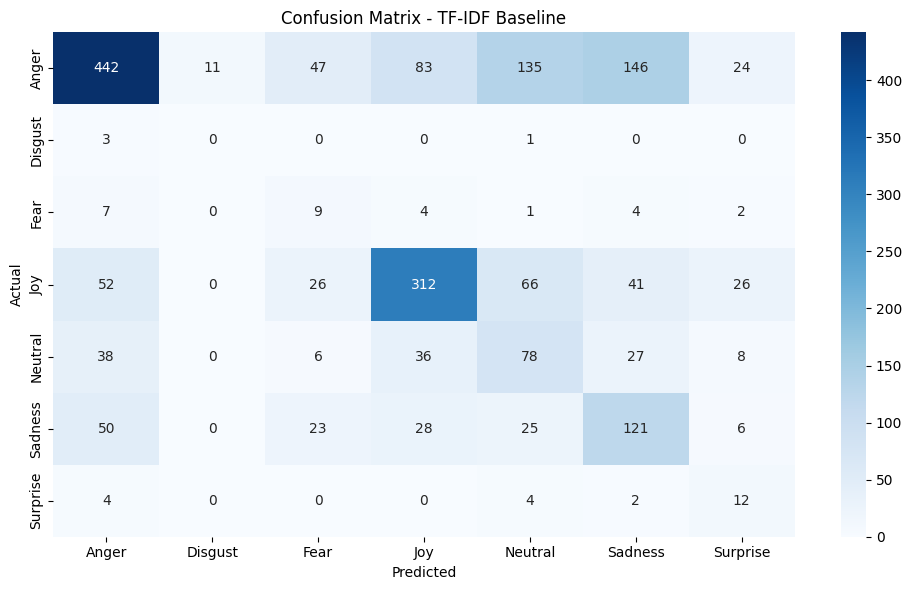

In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Baseline TF-IDF + Logistic Regression
print("\n--- Running TF-IDF + Logistic Regression Baseline ---")
vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = vectorizer.fit_transform(df['clean_text']).toarray()
y = df['emotion_label'].values

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, stratify=y, random_state=42)

baseline_model = LogisticRegression(max_iter=1000, class_weight='balanced')
baseline_model.fit(X_train, y_train)

baseline_preds = baseline_model.predict(X_test)



print("\nBaseline Classification Report:")
print(classification_report(y_test, baseline_preds, target_names=le.classes_))
print("Baseline Accuracy:", accuracy_score(y_test, baseline_preds))
print("Baseline F1 Score:", f1_score(y_test, baseline_preds, average='weighted'))

cm = confusion_matrix(y_test, baseline_preds)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title("Confusion Matrix - TF-IDF Baseline")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Modular Multimodal Classifier
class MultimodalClassifier(nn.Module):
    def __init__(self, num_classes, use_text=True, use_audio=True, use_video=True):
        super(MultimodalClassifier, self).__init__()
        self.use_text = use_text
        self.use_audio = use_audio
        self.use_video = use_video

        if use_text:
            self.bert = BertModel.from_pretrained("bert-base-uncased")
            self.bert.requires_grad = False

        if use_audio:
            self.audio_proj = nn.Sequential(
                nn.Flatten(),
                nn.Linear(128 * 13, 768),
                nn.ReLU(),
                nn.Dropout(0.3)
            )

        if use_video:
            self.video_proj = nn.Sequential(
                nn.Linear(2048, 768),
                nn.ReLU(),
                nn.Dropout(0.3)
            )

        input_dim = 0
        if use_text:
            input_dim += 768
        if use_audio:
            input_dim += 768
        if use_video:
            input_dim += 768

        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, text_inputs, audio_features, video_features):
        features = []

        if self.use_text:
            input_ids = text_inputs['input_ids']
            attention_mask = text_inputs['attention_mask']
            text_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            cls_embedding = text_output.last_hidden_state[:, 0, :]
            features.append(cls_embedding)

        if self.use_audio:
            audio_emb = self.audio_proj(audio_features)
            features.append(audio_emb)

        if self.use_video:
            video_emb = self.video_proj(video_features)
            features.append(video_emb)

        combined = torch.cat(features, dim=1)
        return self.classifier(combined)

# Training Function
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    start_time = time.time()
    for batch in tqdm(dataloader, desc="Training"):
        optimizer.zero_grad()
        inputs = {k: v.to(device) for k, v in batch['text_features'].items()}
        audio = batch['audio_features'].to(device)
        video = batch['video_features'].to(device)
        labels = batch['emotion_label'].to(device)

        outputs = model(inputs, audio, video)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    end_time = time.time()
    print(f"Training time: {end_time - start_time:.2f} seconds")
    return total_loss / len(dataloader)

# Evaluation Function
def evaluate(model, dataloader, criterion, device, label_names):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0
    start_time = time.time()
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            inputs = {k: v.to(device) for k, v in batch['text_features'].items()}
            audio = batch['audio_features'].to(device)
            video = batch['video_features'].to(device)
            labels = batch['emotion_label'].to(device)

            outputs = model(inputs, audio, video)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    end_time = time.time()
    print(f"Evaluation time: {end_time - start_time:.2f} seconds")

    acc = np.mean(np.array(all_preds) == np.array(all_labels))
    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=label_names))

    cm = confusion_matrix(all_labels, all_preds)
    print("\nConfusion Matrix:")
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    disp.plot(xticks_rotation=45, cmap='Blues')
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    return total_loss / len(dataloader), acc

# Run different modality combinations
modalities = {
    "text_only": {"use_text": True, "use_audio": False, "use_video": False},
    "text_audio": {"use_text": True, "use_audio": True, "use_video": False},
    "text_video": {"use_text": True, "use_audio": False, "use_video": True},
    "full_model": {"use_text": True, "use_audio": True, "use_video": True}
}

for name, settings in modalities.items():
    print(f"\n--- Training model: {name.upper()} ---")
    model = MultimodalClassifier(num_classes=len(le.classes_), **settings).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(3):
        print(f"\nEpoch {epoch+1}/3")
        train_loss = train(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device, le.classes_)
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    print(f"\nEvaluating on Test Set for {name.upper()}...")
    test_loss, test_acc = evaluate(model, test_loader, criterion, device, le.classes_)
    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")


# Temporary test code May yield better results

In [ ]:
# Run this cell first.  Sets seeds, defines helper utilities and constants.

import os, random, numpy as np, pandas as pd
from collections import Counter
from tqdm import tqdm

import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from transformers import (
    BertTokenizer,
    BertModel,
    get_linear_schedule_with_warmup,
)
from sklearn.metrics import classification_report

SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def seed_everything(seed: int = SEED):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed); torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

In [ ]:
#   tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
#   ds = MultimodalEmotionDataset(df, tokenizer)
# ---------------------------------------------------------------------------

class MultimodalEmotionDataset(Dataset):
    def __init__(self, df: pd.DataFrame, tokenizer: BertTokenizer, max_len: int = 128):
        self.df, self.tk, self.max_len = df.reset_index(drop=True), tokenizer, max_len
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        enc = self.tk(row["text"], padding="max_length", truncation=True,
                      max_length=self.max_len, return_tensors="pt")
        audio = np.load(row["audio_path"], allow_pickle=False).astype(np.float32)
        video = np.load(row["video_feat"], allow_pickle=False).astype(np.float32)
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "audio": torch.tensor(audio),
            "video": torch.tensor(video),
            "label": torch.tensor(row["label"], dtype=torch.long),
        }


In [ ]:
# Instantiate with: model = MultimodalClassifier(num_classes)
# ---------------------------------------------------------------------------

class MultimodalClassifier(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        # fine‑tune last 4 layers only
        for name, param in self.bert.named_parameters():
            param.requires_grad = False
            if any(name.startswith(f"encoder.layer.{i}.") for i in range(8,12)) or "pooler" in name or "LayerNorm" in name:
                param.requires_grad = True
        self.audio_net = nn.Sequential(nn.Flatten(), nn.Linear(13*128,768), nn.ReLU(), nn.Dropout(0.3))
        self.video_net = nn.Sequential(nn.Linear(2048,768), nn.ReLU(), nn.Dropout(0.3))
        self.classifier = nn.Sequential(nn.Linear(768*3,512), nn.ReLU(), nn.Dropout(0.3), nn.Linear(512,num_classes))
    def forward(self, input_ids, attention_mask, audio, video):
        txt = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:,0,:]
        return self.classifier(torch.cat([txt, self.audio_net(audio), self.video_net(video)], dim=1))


In [ ]:
# Call create_training_objects(labels, model, epochs, lr) to get them.
# ---------------------------------------------------------------------------

def class_weights_tensor(labels):
    freq = Counter(labels); max_f = max(freq.values())
    return torch.tensor([max_f/freq[i] for i in sorted(freq)], dtype=torch.float)

def create_training_objects(train_labels, model, epochs: int, lr: float = 2e-5):
    optimizer = torch.optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=lr, weight_decay=1e-2)
    total_steps = epochs * len(train_loader)
    scheduler = get_linear_schedule_with_warmup(optimizer, int(0.1*total_steps), total_steps)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor(train_labels).to(DEVICE))
    scaler = GradScaler()
    return optimizer, scheduler, criterion, scaler


In [ ]:
# Functions: train_epoch, evaluate, train_fit
# ---------------------------------------------------------------------------

def train_epoch(model, loader, criterion, optimizer, scaler, scheduler):
    model.train(); loss_sum=0
    for batch in tqdm(loader, leave=False):
        optimizer.zero_grad(set_to_none=True)
        batch = {k:v.to(DEVICE) for k,v in batch.items()}
        with autocast():
            logits = model(batch["input_ids"], batch["attention_mask"], batch["audio"], batch["video"])
            loss = criterion(logits, batch["label"])
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)
        scaler.step(optimizer); scaler.update(); scheduler.step()
        loss_sum += loss.item()*batch["label"].size(0)
    return loss_sum/len(loader.dataset)

def evaluate(model, loader, criterion):
    model.eval(); loss_sum, preds, gts = 0, [], []
    with torch.no_grad():
        for batch in loader:
            batch = {k:v.to(DEVICE) for k,v in batch.items()}
            logits = model(batch["input_ids"], batch["attention_mask"], batch["audio"], batch["video"])
            loss = criterion(logits, batch["label"])
            loss_sum += loss.item()*batch["label"].size(0)
            preds += logits.argmax(1).cpu().tolist(); gts += batch["label"].cpu().tolist()
    return loss_sum/len(loader.dataset), np.mean(np.array(preds)==np.array(gts)), preds, gts


In [ ]:
# Use this as single entry‑point after you prepared DataFrames.
# ---------------------------------------------------------------------------

def run_training(train_df, val_df, test_df, num_classes, bs=16, epochs=30):
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    global train_loader  # for create_training_objects scope
    train_loader = DataLoader(MultimodalEmotionDataset(train_df, tokenizer), batch_size=bs, shuffle=True, num_workers=4)
    val_loader   = DataLoader(MultimodalEmotionDataset(val_df,   tokenizer), batch_size=bs, num_workers=4)
    test_loader  = DataLoader(MultimodalEmotionDataset(test_df,  tokenizer), batch_size=bs, num_workers=4)

    model = MultimodalClassifier(num_classes).to(DEVICE)
    opt, sch, crit, scaler = create_training_objects(train_df["label"].values, model, epochs)

    best, wait, PATIENCE = 1e9,0,5
    for ep in range(1,epochs+1):
        print(f"\nEpoch {ep}/{epochs}")
        tl = train_epoch(model, train_loader, crit, opt, scaler, sch)
        vl, va, _, _ = evaluate(model, val_loader, crit)
        print(f"Train {tl:.4f} | Val {vl:.4f} | Acc {va:.4f}")
        if vl<best: best,wait = vl,0; torch.save(model.state_dict(),"best.pt")
        else: wait+=1; print("wait",wait);
        if wait>=PATIENCE: print("Early stop"); break
    # Test
    model.load_state_dict(torch.load("best.pt"))
    tl,ta,p,g = evaluate(model, test_loader, crit)
    print(f"Test loss {tl:.4f} | Test acc {ta:.4f}\n", classification_report(g,p,digits=4))
